In [1]:
import os
import sys
sys.path.insert(0, "C:\\Users\\Matt\\Desktop\\orbithunter\\")
import orbithunter as oh
import numpy as np
import itertools
import time
import matplotlib.pyplot as plt
from math import pi

# Table of contents
<a id='toc'></a>

## [1. Overview: Why orbithunter?](#intro)
    Why and when you should use orbithunter. 

# [2. Examples with the Kuramoto-Sivashinsky Equation](#KSE)
    Demonstrations of utilities using a specific equation

## [2.1 Initialization](#init)
    How to initialize an Orbit with no prior information

## [2.2 Orbit Hunting via Machine Learning (Numerical Optimization)](#hunt)
    How to apply custom and SciPy's numerical methods to search for solutions

## [2.3 Clipping: Extracting Subdomains](#clip)
    Extracting spatiotemporal subdomains from larger Orbits

## [2.4 Reading and Writing Orbit Data](#io)
    Detecting orbits which manifest within others; the theoretical motivation behind this project.

## [2.5 Gluing: Building Blocks of Turbulence](#glue)
    Combining spatiotemporal configurations of orbits; using orbits as literal building blocks.

## [2.6 Shadowing: Detecting Orbits in Other Orbits](#shadow)
    Detecting orbits which manifest within others; the theoretical motivation behind this project.
    
# [Extras](#extras)

## [E.1 Gudhi](#gudhi)
    How to use orbits with Gudhi, persistent homology tools (if extra package requirements are satisfied)

## [E.2 Keras](#keras)
    How to use orbits with Keras (if extra package requirements are satisfied)

    
## [E.3 Technical notes from the author](#footnotes)
    Comments on various portions of the notebooksfor a more technical audience


# 1. Overview: Why orbithunter?

<a id='intro'></a>

## A terse non-technical explanation

Certain equations are hard to solve for two reasons: 1. the number of variables, 2. the relations between those variables.
In fact, for a certain class of equations, nonlinear equations, there are seldom any exact solutions; they must
be solved using computers. In certain settings this is hard, even for computers to manage, and so new tools
must be developed. Orbithunter offers itself as one of these tools. 


## How to do it

By formulating turbulence as a space-time, variational formulation we can still find the same periodic orbits
in the dynamical systems approach; however, spacetime affords us with new capabilities not seen elsewhere. such as:

- The ability to find exponentially unstable solutions starting with modulated random noise
- The ability to include spatiotemporal domain sizes to vary as free parameters; essentially allowing the equations to     determine the important scales (or "learn" in machine learning parlance). 
- The ability to cut and paste (quite literally) periodic orbits together in a manner that is both supported by theory
  and also previously attempted in fluid dynamics research. 

# 2. Examples using the Spatiotemporal Kuramoto-Sivashinsky Equation
**[Return to table of contents](#toc)**
<a id='KSE'></a>

## 2.1 Orbit Initialization

**[Return to table of contents](#toc)**
<a id='init'></a>

Initial conditions can be easily initialized with random modulated noise by 

    1. Initialize an OrbitKS instance
    2. Use the populate method to fill its parameters and state

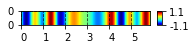

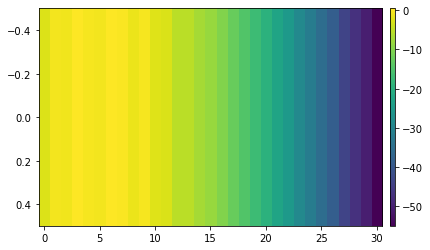

In [5]:
np.random.seed(99)
orbit = oh.EquilibriumOrbitKS().populate(seed=99, attr='all',
                              temporal_modulation='truncate')
orbit.plot(padding=True)
orbit.mode_plot()

The plots correspond to the physical field and the spectrum of spatiotemporal Fourier modes populated by modulation
via a specific choice out of a collection various strategies that are best left explained elsewhere. 

In [3]:
res = orbit.cost()
print(f"The cost function before any numerical optimization is equal to {res:.5f}")

The cost function before any numerical optimization is equal to 1.73008


## 2.2 Orbit Hunting via Machine Learning (Numerical Optimization)

**[Return to table of contents](#toc)**
<a id='hunt'></a>

Orbithunter offers high-level access to the SciPy ```optimize```, ```minimize``` and ```sparse.linalg``` solvers and
more. This allows the user to not have to figure out the specific type of input, parse the output, or learn the more involved
entities within SciPy. A soon as the user defines the methods
which can compute their equations, and compute the matrix-vector products with its Jacobian and its adjoint (transpose or complex conjugate, they immediately have access to over ***40 numerical algorithms!!!***

While numerical optimization is always available, finding a solution which constitutes an actual periodic orbit within
a prescribed tolerance is never guaranteed. Let's apply some machine learning methods (numerical optimization of a cost function) to try to find a solution!

In [ ]:
# Apply the hybrid method that was used as the primary method, historically. 
t0 = time.time_ns()/10**9
hunting_result = oh.hunt(orbit, verbose=False, preconditioning=True, maxiter=100000, pexp=(1, 4))
t1 = time.time_ns()/10**9
print(f"The numerical optimization took {t1-t0} seconds to complete {hunting_result.maxiter} adjoint descent steps")

While it took a couple minutes, the residual of the cost function was reduced from $\mathcal{O}(10^{5})$ to $\mathcal{O}(10^{-1})$ without much effort! The corresponding velocity field has begun to look more like a "typical" solution of the KSE.

In [ ]:
hunting_result.orbit.plot(padding=True)
hunting_result.orbit.mode_plot()

In [ ]:
# # Apply the hybrid method that was used as the primary method, historically.
# t0 = time.time_ns()/10**9
# hunting_result = hunt(orbit, methods=('adj', 'lstsq'), preconditioning=True, maxiter=[100000, 20], verbose=True)
# t1 = time.time_ns()/10**9
# print(f"The numerical optimization took {t1-t0} seconds to complete {hunting_result.maxiter} adjoint descent steps")

## 2.3 Clipping: Extracting Subdomains

**[Return to table of contents](#toc)**
<a id='clip'></a>

Numerical optimization is not the main contribution of orbithunter; in fact creating random initial conditions and finding solutions from them, while impressive (we boast) can be done in a much smarter method. 

The domains can be extracted either via the ```clip``` utility or via regular array slicing! The benefit of the
more contrived ```clip``` is the ability to specify dimensions from the visualization as opposed to having to guess
array indices; also, you can specify the ```Orbit``` type to return the result as by passing a type to the argument 
```clipping_type```, e.g. ```clipping_type=RelativeOrbitKS``` (note: type not instance)

First however let us import a submodule that has an integration routine defined. 

In [ ]:
import orbithunter.ks.physics as ks

In [ ]:
integrated_trajectory = oh.OrbitKS(parameters=(500, 500)).populate(attr='state', seed=0)
# First only return the endpoint so memory is not allocated for the entire integrated trajectory. 

integrate_keywords = {'integration_time':1000, 'verbose':True,
                                          'starting_point':0, 'step_size':0.25, 'return_trajectory':False}
integrated_trajectory = ks.integrate(integrated_trajectory, **integrate_keywords)
print('')
# alternative handling of keyword arguments for example
integrated_trajectory = ks.integrate(integrated_trajectory, integration_time=500, verbose=True,
                                          starting_point=0, step_size=0.25, return_trajectory=True)

In [ ]:
integrated_trajectory = integrated_trajectory.resize(1024,512)
integrated_trajectory.plot(padding=False)

Domains can be extracted either via the ```clip``` utility or via regular array slicing! The benefit of the
more contrived ```clip``` is the ability to specify dimensions from the visualization as opposed to having to guess
array indices; also, you can specify the ```Orbit``` type to return the result as by passing a type to the argument 
```clipping_type```, e.g. ```clipping_type=RelativeOrbitKS``` (note: type not instance)

In [ ]:
sliced_subdomain = integrated_trajectory[-64:, :32]
clipped_subdomain = oh.clip(integrated_trajectory, ((0, sliced_subdomain.t), (0, sliced_subdomain.x/(2*pi*np.sqrt(2)))))
integrated_trajectory[-64:, :32].plot()
clipped_subdomain.plot()

Show that the clippings are in fact exactly the same by plotting the difference of the fields

In [ ]:
(sliced_subdomain-clipped_subdomain).plot()

These clippings can be used to find larger orbits, but first it would befit us to find the orbit that we claim
these clippings shadow. 

In [ ]:
t0 = time.time_ns()/10**9
methods=('adj', 'minres')
clip_result = oh.hunt(clipped_subdomain.transform(to='modes').resize(32,32), maxiter=[200000, 50],
                      methods=methods, preconditioning=True, verbose=True)
t1 = time.time_ns()/10**9
print(''.join([f"Numerical optimization with methods={methods} took {t1-t0} seconds to compute {clip_result.nit}"
               f" iterations and finished with residual {clip_result.orbit.cost()}."]))

In [ ]:
clip_result.orbit.plot(padding=True)
clip_result.orbit.mode_plot()

The idea is "simple" instead of describing chaotic nonlinear pdes as
exponentially unstable dynamical systems (initial value problem) it is instead treated as a $(D+1)$ dimensional boundary value problem. This work only uses variational methods; time integration is possible but it is in no way involved
in the optimization or any other process.

## 2.4 Reading and Writing Orbit Data

**[Return to table of contents](#toc)**
<a id='io'></a>

Before proceeding to the next section, using Orbits as the building blocks of turbulence, it is
useful to read in saved Orbit data that corresponds to fully converged solutions (not a requirement for saving, of course).
This is accomplished via Orbithunter high-level API which allows for quick and convenient importation using the ```h5py```
package.

All that the user must do is have previously saved an Orbit instance using its ```Orbit.to_h5()``` method.
This essentially writes the state array as a h5py.Dataset and the Orbit's attributes as its attributes.
To read in a single or multiple Orbits, all that is required is providing a filename and the names of h5py.Datasets 
(or h5py.Groups !) within the file.

In [ ]:
# provide dataset/group names as separate arguments or as tuple.
imported_orbits = oh.read_h5('../data/ks/tiles.h5', "default/double_streak", "default/defect", "default/double_streak")
imported_orbits

For convenience, these can also be imported as a dictionary using the ```read_tileset``` function and provided keys along
with the dataset names

In [ ]:
# provide dataset/group and keys as tuples
imported_orbit_dict = oh.read_tileset('../data/ks/tiles.h5', (0, 1, 2),
                                      ("default/double_streak", "default/defect", "default/wiggle"))
imported_orbit_dict

A ```h5py.Group``` can be thought of as a folder/directory like structure which contains ```h5py.Dataset``` objects. If a mixture of group and dataset names are provided, an intuitive list is returned; elements corresponding to groups are themselves lists, single datasets are objects. I.e.
 

In [ ]:
dataset_and_group_names = ("default/double_streak", "default/", "default/double_streak")
[type(x) for x in oh.read_h5('../data/ks/tiles.h5', dataset_and_group_names)]

## 2.5 Gluing: Building Blocks of Turbulence

**[Return to table of contents](#toc)**
<a id='glue'></a>

One of the most impressive accomplishments is the ability to use ```Orbit```s as many have thought should be possible;
as the building blocks of turbulence. Given a dictionary whose values are Orbits, we can translate arrays of keys into
arrays of orbits, and then ```glue``` or ```tile``` those orbits together. 


In [ ]:
np.random.seed(5)
symbol_array = (3*np.random.rand(3, 3)).astype(int)
symbol_array

The ```tile``` function simply acts as an interface for the ```glue``` function which accepts arrays of symbols as opposed to arrays of Orbits. Hopefully the correspondence between the symbol array (above) and its glued Orbit representation (below) can be seen.

In [ ]:
tiled_orbit = oh.tile(symbol_array, imported_orbit_dict, oh.RelativeOrbitKS)
tiled_orbit.plot()

What do we do with this? The most obvious use is to use it as an initial condition for an Orbit hunt.

In [ ]:
t0 = time.time_ns()/10**9
tiled_hunt_result = oh.hunt(tiled_orbit.resize().transform(to='modes'), methods=('minres'), verbose=True)
t1 = time.time_ns()/10**9
print(''.join([f"Numerical optimization with methods={methods} took {t1-t0} seconds to compute {clip_result.nit}"
               f" iterations and finished with residual {clip_result.orbit.cost()}."]))

In [ ]:
tiled_hunt_result.orbit.plot(padding=True)

## 2.6 Shadowing: Detecting Orbits in Other Orbits

**[Return to table of contents](#toc)**
<a id='shadow'></a>

One of the more involved computations is to search for the shadowing of smaller orbits within larger orbits. This
component of orbithunter is still in flux due to how difficult it was to generalize to arbitrary shapes and geometries; I think I went slightly overboard with this part. 

The main utilities are ```shadow```, ```cover```, ```fill```. The main concepts/terminology needed to understand these
functions are the following.

**Base Orbit** : An Orbit or near Orbit that is of large spatiotemporal extent

**Window** : A subdomain of spacetime; kernel of convolutional neural network for those with CNN experience.  

**Window Orbit** : An Orbit whose state will be searched for in the base orbit.

**Pivot** : "Top left corner" (first element, 0 along each axis) position of the window within the base orbit. Each window
position is identified by its "pivot" and its "span" (dimensions). For example; a window with dimensions (32, 32, 32)
at a pivot of (1, 2, 3) would have indices in the extent (range(1, 33), range(2, 34), range(3, 35)), before any boundary conditions are taken into account.  

**Shadowing** : When an orbit appears as a subdomain within another, larger Orbit. Developed in periodic orbit theory.

**Cover** : The process of using a collection of windows to find shadowing detections, with the hope that every region of spacetime contains a detection of an orbit. Each window is scores independently, unless replacement=False. 

**Fill** : Same as cover, except all windows are scored simultaneously. For each position, whichever window has the best score is recorded, creating an empirical distribution of the proportion of area covered by each window. 

The metric for detecting shadowing is a highly delicate/unknown problem still under investigation, as such, I made it so that it can be provided as a callable which can return anything that can bhe stored in a float dtype numpy array. 
Provided below are the sco

In [ ]:
def catmap(coordinates, **kwargs):
    return np.concatenate(tuple(coord[np.where(image==0)].reshape(1,-1) for coord in coordinates))

from orbithunter.shadowing import _pad_orbit_with_hull
base = oh.read_h5('./local/small_patches.h5', '0')
hull = (32, 32)
periodicity=(False, False)
mask = np.ones(_pad_orbit_with_hull(base, hull, periodicity).shape,dtype=bool)
mask = (1000*np.random.rand(*mask.shape)).astype(int).astype(bool)
# mask[63, 63]=False
plt.imshow(mask)

t0l2=time.time_ns()/10**9
joke_cover = oh.cover(base, imported_orbits[-1:],[10**9], 
                               replacement=False,
                               min_overlap = 1,
                               base_orbit_periodicity=(False, False),
                               coordinate_map=catmap,
                               mask=mask,
                               return_type='all',
                               verbose=True)
t1l2=time.time_ns()/10**9
print('\ndefault metric covering took {:.2f} seconds to complete'.format(t1l2-t0l2))

joke = OrbitKS(**{**vars(base), 'state':joke_cover[2].min(axis=0)})
base.mask(joke_cover[3].any(axis=0), invert=True).plot(figsize=(14, 14), filename='cat_map.pdf')

Likewise, it is often the case that "odd" geometries; those which do not mimic n-dimensional arrays, are shadowed. For example,
would be advection occurring in fluid flow; an orbit may be shadowed while the mean flow carries the coherent shape down the pipe, for example.  

# Extra comments
**[Return to table of contents](#toc)**
<a id='extras'></a>

## [E.1 Gudhi](#gudhi)
    How to use orbits with Gudhi, persistent homology tools (if extra package requirements are satisfied)

## [E.2 Keras](#keras)
    How to use orbits with Keras (if extra package requirements are satisfied)

## Terse technical explanations

One of the main focuses of nonlinear dynamics and chaos research is the phenomenon of turbulence;
often synonymous with the Navier-Stokes equation. In the past twenty or so years, computational advances
have allowed for more advanced numerical experiments and investigations, each of which hoping to illuminate
the dark depths of the phenomenon of turbulence. 

Simulations of fluid flow have been used extensively in control and design problems e.g. airplane wings.
However, to get a general description of turbulence, one that is not bound to specific geometrical boundary conditions,
a more fundamental explanation is needed.

The nonlinear dynamicist's approach was to put turbulence under a microscope, looking at the minimal contains
required to sustain it. Naturally these computations began with "minimal cells"; computational domains large enough to sustain
turbulence yet remain computationally tractable; this might be smaller than you might imagine, representing
only small segments of pipe or plane Couette flow. By abstractifying fluid flow as a traversal of a
high dimensional space (technically infinite), periodic orbit theory was used to show that special solutions,
those which manifest as time invariant sets, shape the geometry of the state-space by virtue of their stable
and unstable manifolds. The instabilities, exponential in nature, prevent any long time prediction and are
the main instigator in all of this. 

We can avoid these exponential instabilities by transforming our exponentially unstable initial value problem into
a variational, dynamics-less boundary value problem; by the conceptual migration to spacetime. This formulates
PDEs as systems of differential algebraic equations, instead.

This walkthrough demonstrates the user friendliness of the orbithunter package as well as its utility in finding unstable periodic orbits of the Kuramoto-Sivashinsky equation. 

These solutions, or initial conditions with which to find solutions, are represented via Python class objects using object oriented programming. Different solutions have different symemtries, which manifest naturally as subclasses. 
These ``Orbit`` objects, the basis of ``orbithunter`` are designed to give high-level access to a complex, scientific API. 

The Orbithunter package currently only supports one equation, however, the [Developer Guide](https://orbithunter.readthedocs.io/en/latest/guide.html) offered on the readthedocs site provides template for
how to implement different equations; the lion's share of the work corresponds to implementing the following numerical methods.


## On hunting

A great example of the instant-access property is in the usage of SciPy's ```sparse.linalg``` solvers. These solvers typically take either a Matrix (2d-array) or one of SciPy's ```LinearOperator``` objects. The benefit of using the ```LinearOperator``` objects is that
functions for matrix-vector products can be passed instead of matrices themselves; saving tons of memory. However, with nonlinear equations these matrices will typically depend on the state itself; meaning that the LinearOperator has to be
updated after everycorrection. 

Orbithunter handles literally all of this within its ```hunt``` function. Therefore, as soon as the user defines the methods
which can compute their equations, and compute the matrix-vector products with its Jacobian and its adjoint (transpose or complex conjugate, they immediately have access to over ***40 numerical algorithms!!!***

I personally like watching output be printed/monitoring the process and so I typically choose ```verbose=True```.
The default numerical method is ```methods='adj'```, one reason for it being the default is that it has access
to the ```preconditioning=True``` keyword argument; it is rescaling the components of the gradient to account for very
stiff linear terms; this includes the changes to domain size, which are rescaled according to 

$\Delta P / P_{\small{\text{current}}}^{k}$

One of the revolutionary abilities of this code is that the domain size is allowed to change, however this must be done
within reason. When starting with random initial conditions and using spectral methods very often the optimization will result in the dimensions $d_i\to\infty$; because the derivatives are inversely proportional to dimension via frequencies $\frac{2\pi n}{d}$